In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F

import math
import matplotlib.pyplot as plt

cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [11]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        
        gate_x = self.x2h(x) 
        gate_h = self.h2h(hidden)
        
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)
        
        
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + (resetgate * h_n))
        
        hy = newgate + inputgate * (hidden - newgate)
        
        
        return hy

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = []
        for i in range(layer_dim):
            if i == 0:
                self.rnn.append(GRUCell(input_dim, hidden_dim))
                continue
            self.rnn.append(GRUCell(hidden_dim, hidden_dim))
        
        self.rnn = nn.ModuleList(self.rnn)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        for idx, layer in enumerate(self.rnn):
            hn = h0[idx,:,:]
            outs = []

            for seq in range(x.size(1)):
                hn = layer(x[:,seq,:], hn) 
                outs.append(hn)

            x = torch.stack(outs, 1)
        
        out = self.fc(x[:, -1, :])
        return out
 

In [13]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
training_epochs = 2


In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [28]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
seq_dim = 28 
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [29]:
training_epochs = 2

In [30]:
loss_list1 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list1.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.3005638122558594. Accuracy: 11.0
Iteration: 100. Loss: 2.289593458175659. Accuracy: 16.179996490478516
Iteration: 200. Loss: 2.2015295028686523. Accuracy: 23.449996948242188
Iteration: 300. Loss: 1.755460500717163. Accuracy: 40.06999588012695
Iteration: 400. Loss: 1.0664833784103394. Accuracy: 60.56999969482422
Iteration: 500. Loss: 0.840258002281189. Accuracy: 68.7199935913086
Iteration: 0. Loss: 0.7814785838127136. Accuracy: 73.1500015258789
Iteration: 100. Loss: 0.7655765414237976. Accuracy: 76.37997436523438
Iteration: 200. Loss: 0.5864498019218445. Accuracy: 80.11998748779297
Iteration: 300. Loss: 0.4280107021331787. Accuracy: 84.55001831054688
Iteration: 400. Loss: 0.3965272605419159. Accuracy: 85.2300033569336
Iteration: 500. Loss: 0.40620216727256775. Accuracy: 88.50003051757812


In [31]:
class Test(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Test, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.linear(x[:,-1,:])
        return out

In [32]:
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  


In [33]:
loss_list2 = []
for epoch in range(training_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)        

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list2.append(loss.item())
         
        if idx % 100 == 0:
            correct = 0
            total = len(test_loader)
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim).to(device)
                labels = labels.to(device)     
                outputs = model(images)
                predicted = torch.argmax(outputs.data, 1)
                correct += (predicted == labels).float().mean()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print(f'Iteration: {idx}. Loss: {loss.item()}. Accuracy: {accuracy}')

Iteration: 0. Loss: 2.3090415000915527. Accuracy: 9.620002746582031
Iteration: 100. Loss: 2.2880775928497314. Accuracy: 16.39999771118164
Iteration: 200. Loss: 2.243562698364258. Accuracy: 28.100004196166992
Iteration: 300. Loss: 1.8788646459579468. Accuracy: 38.589996337890625
Iteration: 400. Loss: 1.2781422138214111. Accuracy: 58.1099967956543
Iteration: 500. Loss: 1.0598578453063965. Accuracy: 67.43000030517578
Iteration: 0. Loss: 0.6621491312980652. Accuracy: 73.4800033569336
Iteration: 100. Loss: 0.6633756756782532. Accuracy: 79.22000122070312
Iteration: 200. Loss: 0.576466977596283. Accuracy: 81.67001342773438
Iteration: 300. Loss: 0.4599093198776245. Accuracy: 81.19001770019531
Iteration: 400. Loss: 0.33247050642967224. Accuracy: 86.72997283935547
Iteration: 500. Loss: 0.3290899991989136. Accuracy: 87.91996765136719


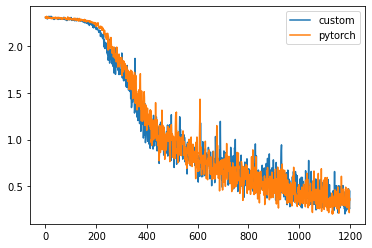

In [34]:
plt.plot(loss_list1, label='custom')
plt.plot(loss_list2, label='pytorch')

plt.legend()
plt.show()